In [3]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tedd\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tedd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tedd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
seed = 17
import numpy as np
import pandas as pd
# Text preprocessing/analysis
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')

In [6]:
sample = pd.read_csv('IMDB Dataset.csv')
print(f"{sample.shape[0]} rows and {sample.shape[1]} columns")
sample.head()

50000 rows and 2 columns


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [19]:
sample['target'] = np.where(sample['sentiment']=='positive', 1, 0)
sample.groupby(['sentiment', 'target']).count().unstack()

review         
target           0        1
sentiment                  
negative   25000.0      NaN
positive       NaN  25000.0

In [30]:
X_train, X_test, y_train, y_test = train_test_split(sample['review'], sample['sentiment'], test_size=5000, random_state=seed, 
                                                    stratify=sample['sentiment'])
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['sentiment'].value_counts()}\n")
print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['sentiment'].value_counts())

Train: 45000 rows and 2 columns
negative    22500
positive    22500
Name: sentiment, dtype: int64

Test: 5000 rows and 2 columns
negative    2500
positive    2500
Name: sentiment, dtype: int64


In [31]:
example = 'Nice Game. Bad Game'
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(example)

{'neg': 0.422, 'neu': 0.241, 'pos': 0.337, 'compound': -0.1779}

In [32]:
train[['neg', 'neu', 'pos', 'compound']] = train['review'].apply(sid.polarity_scores).apply(pd.Series)

In [33]:
train['target'] = np.where(train['sentiment']=='positive', 1, 0)

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


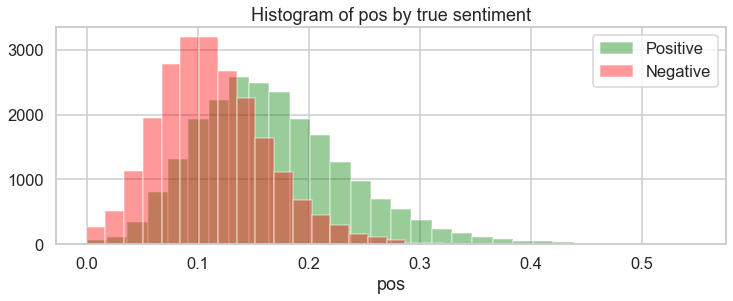

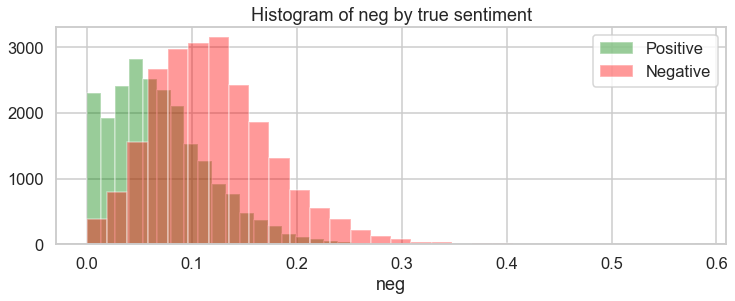

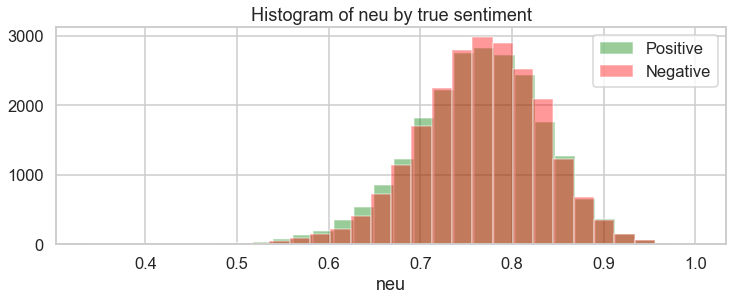

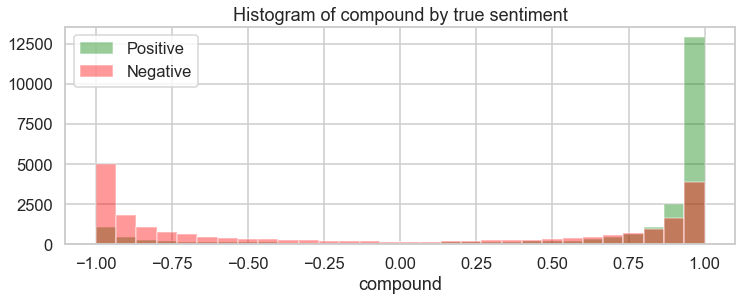

In [34]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='red', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

In [35]:
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.53      0.63     22500
    positive       0.64      0.86      0.74     22500

    accuracy                           0.69     45000
   macro avg       0.72      0.69      0.68     45000
weighted avg       0.72      0.69      0.68     45000



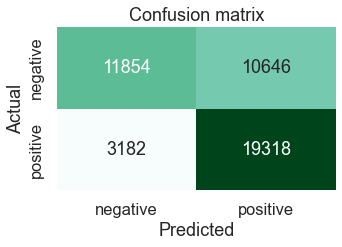

In [36]:
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

plot_cm(train['target'], train['vader_polarity'])

In [37]:
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.54      0.64     22500
    positive       0.65      0.85      0.74     22500

    accuracy                           0.70     45000
   macro avg       0.72      0.70      0.69     45000
weighted avg       0.72      0.70      0.69     45000



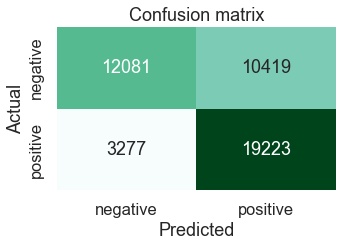

In [38]:
plot_cm(train['target'], train['vader_compound'])

In [39]:
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [40]:
models = create_baseline_models()
models

[('log', LogisticRegression(max_iter=1000, random_state=17)),
 ('sgd', SGDClassifier(random_state=17)),
 ('mnb', MultinomialNB())]

In [41]:
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)
assess(X_train_simpler, y_train, models)

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1132, in f1_score
  

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1132, in f1_score
  

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1132, in f1_score
  

,log,sgd,mnb
fit_time_mean,1.440765,0.224991,0.099306
fit_time_std,0.224506,0.017447,0.008621
score_time_mean,0.930733,0.051895,0.052056
score_time_std,1.974959,0.005571,0.007306
test_accuracy_mean,NaN,NaN,NaN
test_accuracy_std,NaN,NaN,NaN
test_f1_mean,NaN,NaN,NaN
test_f1_std,NaN,NaN,NaN
test_roc_auc_mean,NaN,NaN,NaN
test_roc_auc_std,NaN,NaN,NaN


In [43]:
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens
# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)


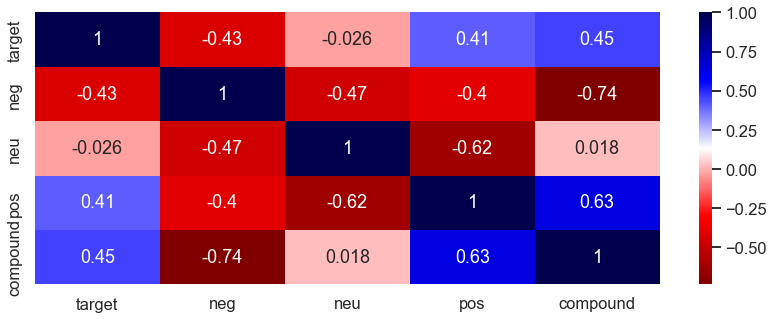

In [45]:
plt.figure(figsize = (14,5))
columns = ['target', 'neg', 'neu', 'pos', 'compound']
sns.heatmap(train[columns].corr(), annot=True, cmap='seismic_r');

In [47]:
# Initialise a model
sgd = SGDClassifier(random_state=seed)
# Initialise a scaler
scaler = MinMaxScaler()
# Assess the model using scores
scores = train[['neg', 'neu', 'pos', 'compound']]
assess(scaler.fit_transform(scores), y_train, [('sgd', sgd)])

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1132, in f1_score
  

,sgd
fit_time_mean,0.055600
fit_time_std,0.006305
score_time_mean,0.049360
score_time_std,0.006159
test_accuracy_mean,NaN
test_accuracy_std,NaN
test_f1_mean,NaN
test_f1_std,NaN
test_roc_auc_mean,NaN
test_roc_auc_std,NaN


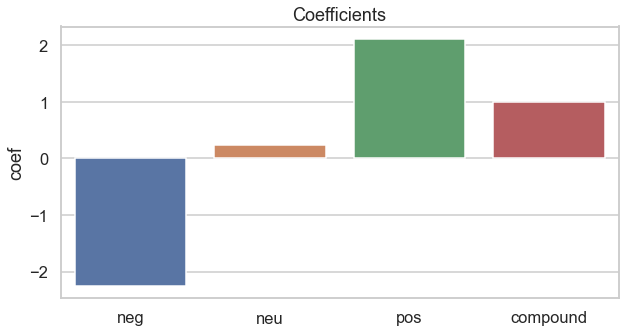

In [48]:
# Fit to training data
sgd.fit(scores, y_train)
# Get coefficients
coefs = pd.DataFrame(data=sgd.coef_, columns=scores.columns).T
coefs.rename(columns={0: 'coef'}, inplace=True)
# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefs.index, y='coef', data=coefs)
plt.title('Coefficients');

In [50]:
# Add features to sparse matrix
selected_scores = train[['neg', 'pos']]
X_train_extended = hstack([X_train_simpler, csr_matrix(scaler.fit_transform(selected_scores))])
# Assess
assess(X_train_extended, y_train, [('sgd', sgd)])

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1132, in f1_score
  

,sgd
fit_time_mean,0.275688
fit_time_std,0.033570
score_time_mean,0.052376
score_time_std,0.008988
test_accuracy_mean,NaN
test_accuracy_std,NaN
test_f1_mean,NaN
test_f1_std,NaN
test_roc_auc_mean,NaN
test_roc_auc_std,NaN


In [51]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])
# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}
r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train, y_train)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [52]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]
r_summary = r_search_results[columns].copy()
r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]
r_summary.columns = columns
r_summary.head()

,min_df,max_df,loss,split0,split1,split2,split3,split4
23,60,0.917949,hinge,0.893778,0.887778,0.895333,0.890222,0.890556
24,90,0.897436,hinge,0.894556,0.887111,0.891889,0.888556,0.887778
12,110,0.323077,hinge,0.889556,0.882556,0.887444,0.886000,0.886778
22,220,0.569231,hinge,0.889889,0.880111,0.883111,0.882333,0.884111
13,220,0.630769,hinge,0.888111,0.879667,0.884778,0.881889,0.884333


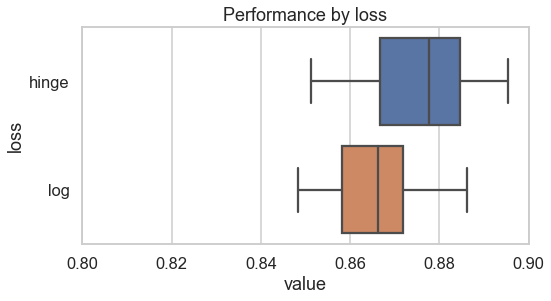

In [53]:
# Create a long dataframe
r_summary_long = pd.melt(r_summary, 
                         id_vars=['min_df', 
                                  'max_df', 
                                  'loss'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
# Plot hyperparameter 'loss'
plt.figure(figsize=(8,4))
plt.title('Performance by loss')
sns.boxplot(x='value', y='loss', data=r_summary_long, 
            orient='h')
plt.xlim(.8, .9);

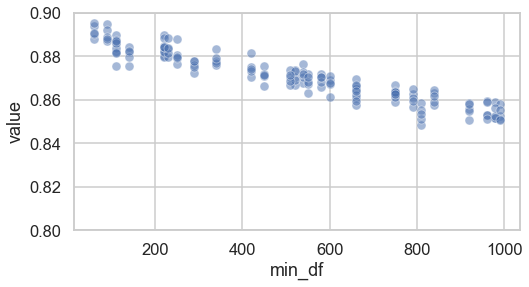

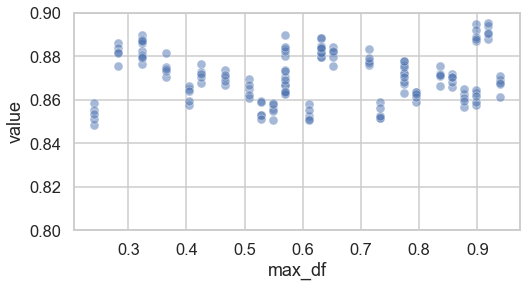

In [54]:
for param in ['min_df', 'max_df']:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=param, y="value", data=r_summary_long, 
                    x_jitter=True, alpha=0.5)
    plt.ylim(.8, .9);

In [55]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 90, 150],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__stop_words': [None, 'english'],
              'model__fit_intercept': [True, False]}
g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)
# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [56]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

,fit_intercept,min_df,ngram_range,stop_words,split0,split1,split2,split3,split4,mean
14,False,30,"(1, 2)",None,0.905556,0.905000,0.909667,0.907889,0.905333,0.906689
2,True,30,"(1, 2)",None,0.905889,0.905222,0.909111,0.907000,0.905444,0.906533
18,False,90,"(1, 2)",None,0.903444,0.896778,0.904000,0.902667,0.901333,0.901644
6,True,90,"(1, 2)",None,0.904000,0.896667,0.903778,0.902333,0.898556,0.901067
22,False,150,"(1, 2)",None,0.900111,0.897000,0.899556,0.897000,0.897444,0.898222


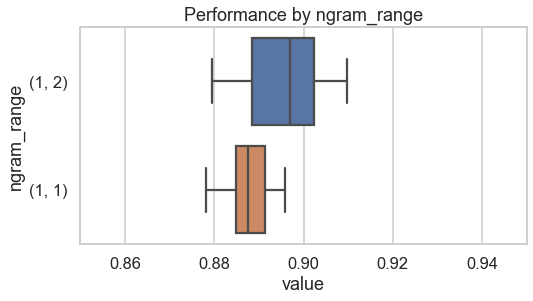

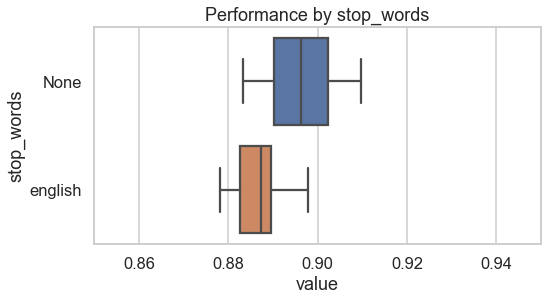

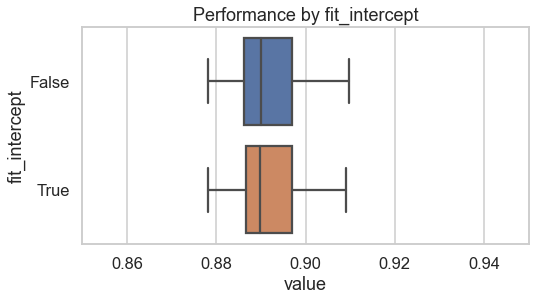

In [57]:
# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['min_df', 
                                  'ngram_range', 
                                  'stop_words', 
                                  'fit_intercept'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)
# Plot performance
for param in ['ngram_range', 'stop_words', 'fit_intercept']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    plt.xlim(.85, .95);

In [58]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.6, min_df=30, ngram_range=(1, 2),
                                 token_pattern='[a-z]+')),
                ('model', SGDClassifier(random_state=17))])

In [59]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

C:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,coef
bad,-4.924933
worst,-4.660290
awful,-3.949683
boring,-3.647068
the worst,-3.611383
...,...
fun,2.496241
wonderful,2.509919
perfect,2.659419
excellent,3.516903


In [60]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94     21985
    positive       0.95      0.93      0.94     23015

    accuracy                           0.94     45000
   macro avg       0.94      0.94      0.94     45000
weighted avg       0.94      0.94      0.94     45000



In [61]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.92      0.90      2427
    positive       0.92      0.89      0.90      2573

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



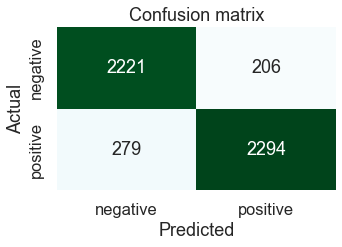

In [62]:
plot_cm(test_pred, y_test, target_names=target_names)

In [63]:
for i in range(10):
    lead = X_test.sample(1)
    %timeit pipe.predict(lead)

853 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.39 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
830 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
764 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
663 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
776 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
802 µs ± 77.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
752 µs ± 7.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
752 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
814 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
